# Demo 3c: Compute on Vertical Sections

In [1]:
%matplotlib inline

# Import OceanSpy
import oceanspy as ospy

# Additional packages
import matplotlib.pyplot as plt

# Import the OceanDataset
od = ospy.open_oceandataset.get_started()

Opening [Getting Started with OceanSpy]:
[A small cutout from EGshelfIIseas2km_ASR.].


/home/idies/miniconda3/lib/python3.7/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


## Mooring

In [2]:
lats_Kogur = [ 68.68,  67.52,  66.49]
lons_Kogur = [-26.28, -23.77, -22.99]
varList    = ['U', 'V', 'dyG', 'dxG', 'drF', 'HFacS', 'HFacW']
od_Kogur_moor = od.subsample.mooring_array(Xmoor=lons_Kogur, 
                                           Ymoor=lats_Kogur,
                                           varList=varList,
                                           timeRange='2007-09-01',
                                           dropAxes=True)

Cutting out the oceandataset.
Extracting mooring array.


### Compute volume flux

In [3]:
od_Kogur_moor = od_Kogur_moor.compute.mooring_horizontal_volume_transport()

Computing horizontal volume transport.


### Plot

<IPython.core.display.Javascript object>


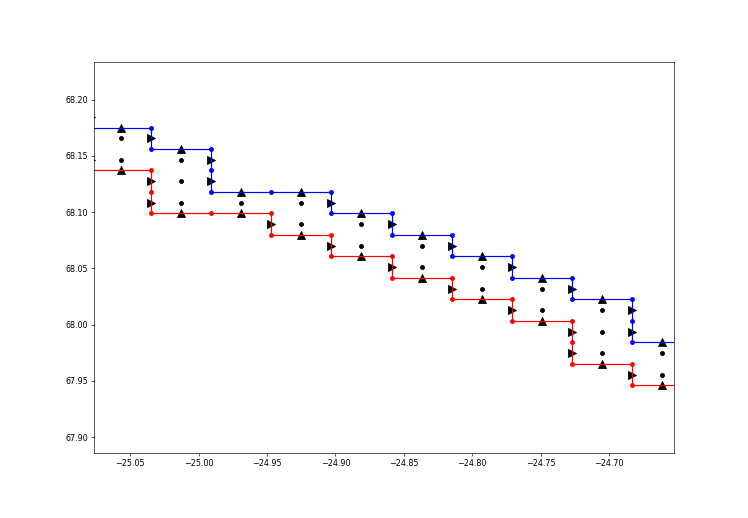

In [4]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(13,9))
ms = 10
s  = 100
_ = ax.step(od_Kogur_moor.dataset['XU'].isel(Xp1=0).squeeze(), 
            od_Kogur_moor.dataset['YV'].isel(Yp1=0).squeeze(), 'r.', ms=ms)
_ = ax.step(od_Kogur_moor.dataset['XU'].isel(Xp1=1).squeeze(), 
            od_Kogur_moor.dataset['YV'].isel(Yp1=1).squeeze(), 'b.', ms=ms)
_ = ax.plot(od_Kogur_moor.dataset['XC'].squeeze(), 
            od_Kogur_moor.dataset['YC'].squeeze(), 'k.', ms=ms)
_ = ax.scatter(od_Kogur_moor.dataset['X_Vtransport'].where(od_Kogur_moor.dataset['dir_Vtransport']==1), 
               od_Kogur_moor.dataset['Y_Vtransport'].where(od_Kogur_moor.dataset['dir_Vtransport']==1),  
               s=s, c='k', marker='^')
_ = ax.scatter(od_Kogur_moor.dataset['X_Utransport'].where(od_Kogur_moor.dataset['dir_Utransport']==1), 
               od_Kogur_moor.dataset['Y_Utransport'].where(od_Kogur_moor.dataset['dir_Utransport']==1),   
               s=s, c='k', marker='>')
_ = ax.scatter(od_Kogur_moor.dataset['X_Vtransport'].where(od_Kogur_moor.dataset['dir_Vtransport']==-1), 
               od_Kogur_moor.dataset['Y_Vtransport'].where(od_Kogur_moor.dataset['dir_Vtransport']==-1), 
               s=s, c='k', marker='v')
_ = ax.scatter(od_Kogur_moor.dataset['X_Utransport'].where(od_Kogur_moor.dataset['dir_Utransport']==-1), 
               od_Kogur_moor.dataset['Y_Utransport'].where(od_Kogur_moor.dataset['dir_Utransport']==-1), 
               s=s, c='k', marker='<')

### Vertically integrated cumulative transport

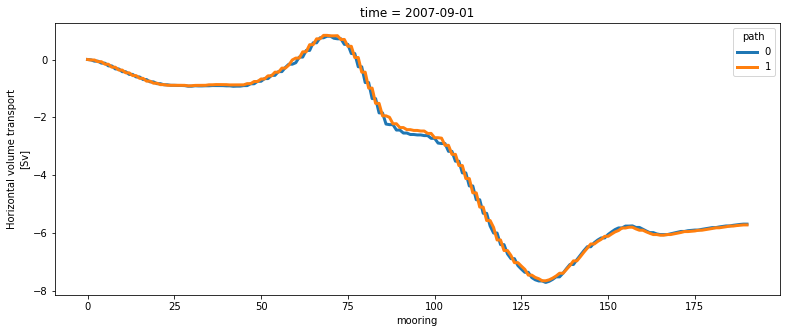

In [5]:
%matplotlib inline
transport     = od_Kogur_moor.dataset.transport
cum_transport = transport.sum('Z').cumsum('mooring')
cum_transport.attrs = transport.attrs
fig, ax = plt.subplots(figsize=(13,5))
lines = cum_transport.squeeze().plot.line(hue='path', linewidth=3)

## Survey

In [6]:
varList = ['U', 'V', 'HFacC', 'HFacW', 'HFacS', 'drC', 'drF']
od_Kogur_surv = od.subsample.survey_stations(Xsurv=lons_Kogur, 
                                             Ysurv=lats_Kogur,
                                             delta=2,
                                             varList=varList,
                                             timeRange='2007-09-01',
                                             dropAxes=True)

Cutting out the oceandataset.
Carrying out survey.
Create weight file: bilinear_118x76_142x142.nc


/home/idies/miniconda3/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Variables to interpolate: ['XC', 'YC', 'XU', 'YU', 'XV', 'YV', 'XG', 'YG', 'HFacC', 'HFacW', 'HFacS', 'U', 'V'].
Interpolating [XC].
Interpolating [YC].
Interpolating [XU].
Interpolating [YU].
Interpolating [XV].
Interpolating [YV].
Interpolating [XG].
Interpolating [YG].
Interpolating [HFacC].


/home/idies/miniconda3/lib/python3.7/site-packages/xesmf/smm.py:73: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


Interpolating [HFacW].
Interpolating [HFacS].
Interpolating [U].
Interpolating [V].
Remove file bilinear_118x76_142x142.nc


### Compute orthogonal velocities

In [7]:
od_Kogur_surv = od_Kogur_surv.compute.survey_aligned_velocities()

Computing survey aligned velocities.


/home/idies/workspace/Storage/malmans2/persistent/ESIP/oceanspy/oceanspy/compute.py:2604: UserWarning: 
These variables are not available and can not be computed: ['AngleCS', 'AngleSN']
Assuming U=U_zonal and V=V_merid
If you are using curvilinear coordinates, run `compute.geographical_aligned_velocities` before `subsample.survey_stations`
  ds = survey_aligned_velocities(self._od, **kwargs)


### Vertically integrated cumulative transport

Computing integrals.


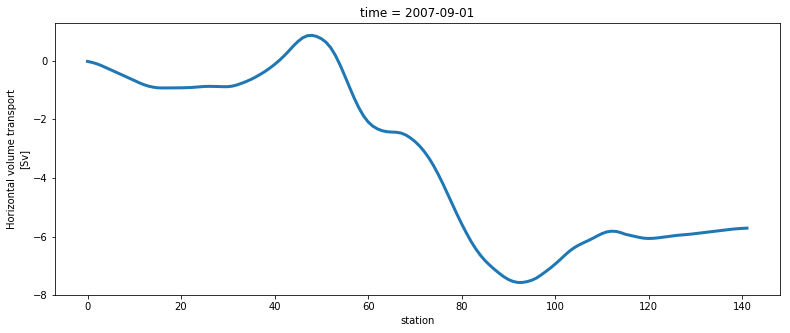

In [8]:
# Use xgcm to compute dists (about 2km everywhere)
grid = od_Kogur_surv.grid
dist = od_Kogur_surv.dataset['station_dist']
dist = grid.interp(grid.diff(dist, 'station'), 'station', boundary='extend')

# Compute cumulative transport
transport = ospy.compute.integral(od_Kogur_surv, 'ort_Vel')
transport = transport['I(ort_Vel)dZ']*dist*1.E3*1.E-6
cum_transport = transport.cumsum('station').rename('Horizontal volume transport')
cum_transport.attrs['units'] = 'Sv'

# Plot
fig, ax = plt.subplots(figsize=(13,5))
lines   = cum_transport.squeeze().plot.line(hue='path', linewidth=3)